### this notebook load calcium data from Bartos lab (Hannah's data) and detect and cluster the sequences. 

In [1]:


# code from laptop
import seaborn as sns

from cmath import nan
from traceback import format_exception_only
#from eagerpy import zeros_like
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.tree import plot_tree
#import mtools as mot
import mtools2 as mot

from scipy.stats import ranksums
from os.path import exists
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.cm as cm
import random
import pickle
import scipy.io as spio
import pandas as pd
import matplotlib.animation as animation
from scipy.signal import find_peaks
import scipy.stats as stats
from rastermap import Rastermap
import scipy.signal
from helper_functions import separate_in,separate_in_2d_array,linearize_2d_track_single_run
import configparser
import os



plt.rcParams['svg.fonttype'] = 'none'  # Export text as SVG <text> objects, not paths
mpl.rcParams['xtick.major.size'] = 6    # Length of major ticks on x-axis
mpl.rcParams['xtick.major.width'] = 1.5 # Width of major ticks on x-axis
mpl.rcParams['xtick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['xtick.major.pad'] = 10    # Padding between ticks and x-axis labels

mpl.rcParams['ytick.major.size'] = 6    # Length of major ticks on y-axis
mpl.rcParams['ytick.major.width'] = 1.5 # Width of major ticks on y-axis
mpl.rcParams['ytick.direction'] = 'in' # Tick direction, both in and out
mpl.rcParams['ytick.major.pad'] = 10    # Padding between ticks and y-axis labels


# Set default spine and tick settings globally for all plots
mpl.rcParams['axes.linewidth'] = 1.5     # Set the width of all spines (top, bottom, left, right)
mpl.rcParams['xtick.major.width'] = 1.5  # Width of major ticks on x-axis
mpl.rcParams['ytick.major.width'] = 1.5  # Width of major ticks on y-axis
mpl.rcParams['xtick.labelsize'] = 12     # Font size of x-axis tick labels
mpl.rcParams['ytick.labelsize'] = 12     # Font size of y-axis tick labels

# Define the helper function to hide spines
def hide_spines(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)












# Initialize the configuration parser
config = configparser.ConfigParser()

# Read the configuration file
config.read('config.ini')# the location of data to load and save

# Get the data folder path from the config file
savefolder= config['paths']['savefolder']
datafolder= config['paths']['datafolder']
skeletonsfolder= config['paths']['skeletonsfolder']

sleep__beforelearning = {'478':['session02','session03'],'480':['session02','session03'],'481':['session02','session03'],'483':['session02','session03'],'485':['session02','session03']}# before learning
sleep_leaned_before = {'478':['session02','session03'],'480':[],'481':['session02'],'483':['session02','session03'],'485':['session02']}# learned before task
sleep_leaned_after = {'478':['session05'],'480':[],'481':['session04'],'483':['session05','session06'],'485':['session04']}# learned after task


days= np.arange(0 ,32)# names to load data
daysstr = ["%02d" % (i,) for i in days]
months = np.arange(0,13)
monthsstr = ["%02d" % (i,) for i in months]
year=str(2022)
dates = []
for m in monthsstr:
    for d in daysstr:
        dates.append(year+m+d)



first_last_dates={}# if you need to compare firest day with last day of recording
first_last_dates['485']= {'first_day': '20220215_gcamp6f485_task_learning', 'last_day': '20220316_gcamp6f485_task_learned'}
first_last_dates['478']= {'first_day': '20220214_gcamp6f478_task_learning', 'last_day': '20220327_gcamp6f478_task_learned'}
first_last_dates['483']= {'first_day': '20220214_gcamp6f483_task_learning', 'last_day': '20220309_gcamp6f483_task_learned'}
first_last_dates['481']= {'first_day': '20220215_gcamp6f481_task_learning', 'last_day': '20220320_gcamp6f481_task_learned'}





## initializtion


In [2]:
folders = ['483']# Name of the animals' folder to analyse
place_cells=False# consider only place cells for analysis(list of the cells should be loaded)
cell_types='All'
nrm = np.load('nrm.npy',allow_pickle=True)
clusteringmethod = 'AHC'# what clustering algorithm will be used
Mode = 0 # this belongs to the old code and can be removed
signal_type = 'transients'
#signal_type = 'traces'
fs=20# sampling freq
thr_burts = .5# threshold for burst detection
winlen = 1000*fs# 10 sec cunnks for burst detection
tau=.001# deconv parameter
SpeedLimint=10# is not applied anymore
min_ratio = 1 # threshold to exclude bad templates

speed_thr=0# threshold to remove datapoint with low speed (Must be always  0, otherwise wrong results)
burst_length=0.5 # Duration of bursts (hardcoded in mtools (Tspare=.5))
burst_len=str(burst_length)+'s'


if clusteringmethod =='DB':# clustering algorithm
    clstr_param={'name':'DB', 'eps':3, 'min_samples': 10}
    cluster_decription = 'Name=' +clstr_param['name']+ ' eps=' +str(clstr_param['eps']) + ' minsample='+ str(clstr_param['min_samples'])+'  SpeedLimint='+ str(SpeedLimint)

elif clusteringmethod =='AHC':
    clstr_param={'name':'AHC', 'fac' : 1,'clnbr':10}
    cluster_decription='Name=' +clstr_param['name']+ ' fac=' +str(clstr_param['fac']) +'  SpeedLimint='+ str(SpeedLimint)



task = ['task_learning','task_learned']
print('Taks that are used to compute active cells: ', *task, sep=' and ')




Taks that are used to compute active cells:  and task_learning and task_learned


## Get the index of cells that are acitve in all sessions

task_learning
483/20220214_gcamp6f483_task_learning.mat
483/20220215_gcamp6f483_task_learning.mat
483/20220216_gcamp6f483_task_learning.mat
483/20220217_gcamp6f483_task_learning.mat
task_learned
483/20220306_gcamp6f483_task_learned.mat
483/20220307_gcamp6f483_task_learned.mat
483/20220308_gcamp6f483_task_learned.mat
483/20220309_gcamp6f483_task_learned.mat
483/20220315_gcamp6f483_task_learned.mat
Number of active cells during tasks  93


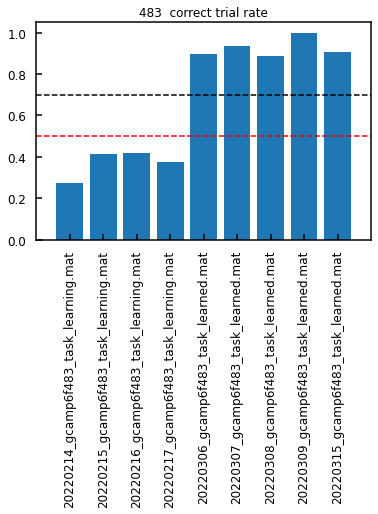

In [3]:
trial_number={}
correctrate=[]
failedrate=[]
true_cell_idx=[]
use_uniqueindex=True

if use_uniqueindex==True:# finding the index of active cells thoughout all sessions
    cmnidx=[]
    cellids=[]# find unique index of all sessions(active cells during all cessions)
    for t in range(len(task)):# task
        print(task[t])
                
        for ii,date in enumerate(dates):# session date
                    
            for i ,fol in enumerate(folders):# animal number
                
                if task[t] == 'sleep_learned_after':
                    filename = date+'_gcamp6f'+fol+'_'+task[t-1]+'.mat'
                else:
                    filename = date+'_gcamp6f'+fol+'_'+task[t]+'.mat'
                            
                if exists(datafolder+fol+'/'+filename):
                    
                    
                    if task[t] == 'sleep_learned_after':
                        filenames = [date+'_gcamp6f'+fol+'_'+task[t]+'.mat'[:-4]+'_'+signal_type]
                    else:
                        filenames = [filename[:-4]+'_'+signal_type]


                    data = mot.loadmat(datafolder+fol+'/'+filename)
                    print(fol+'/'+filename)


                    if (task[t]=='task_learning') | (task[t]=='task_learned'):
                        failedrate.append((filename,len(data['EvtT']['failed_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials']))))
                        correctrate.append((filename,len(data['EvtT']['correct_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials']))))

                    true_cell_idx.append(data['metadata']['CellRegCellID'])



name_failedrate=[x[0] for x in correctrate]
value_faliedrate=[x[1] for x in correctrate]


plt.figure()# plot correct trial rate
plt.bar(name_failedrate,value_faliedrate)
plt.xticks(rotation=90)
plt.title(fol+'  correct trial rate')
plt.hlines(.7,-1,len(name_failedrate)+1,'k',linestyles='dashed')
plt.hlines(.5,-1,len(name_failedrate)+1,'r',linestyles='dashed')
plt.xlim([-1,len(name_failedrate)])


session_mask={}
for i,x in enumerate(name_failedrate): # assign a number to each session for masking sessions
    session_mask[x]=i



newidx=[]
true_cell_idx2=np.array(np.transpose(true_cell_idx))# cell index of all sessions
for x in range(np.shape(true_cell_idx2)[0]):
    if not -1 in (true_cell_idx2[x,:]):
        newidx.append(x)# insex of cells that are active in all sessions

mask_commonids = np.zeros(np.shape(true_cell_idx2)[0],dtype=bool)
mask_commonids[newidx] = True
ncells = len(newidx)# number of active cells in all sessions
failedrate=[]

print('Number of active cells during tasks ', ncells)

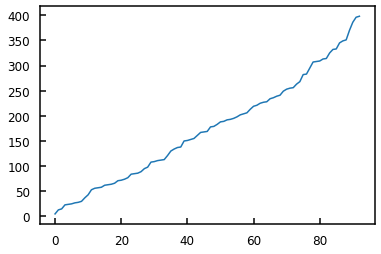

In [4]:
plt.plot(newidx)

# load skleton files and inedex of Place cells

In [5]:



skel = np.load(skeletonsfolder+fol+'_skeleton.npy',allow_pickle=True) 
skel=skel.item()

if place_cells:
    dir_of_run='L'
    saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
    sig_pc_L=saved_idx['sig_PC']

    dir_of_run='R'
    saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
    sig_pc_R=saved_idx['sig_PC']


    significant_pc=sig_pc_L|sig_pc_R
    cell_types='PC'
    #cell_types='non_pc'

    if cell_types=='Non_PC':
        significant_pc=~significant_pc
elif place_cells==False:
        cell_types='All'

place_cell_name=cell_types


## Load data of different sessions and merge them.

In [6]:
filename

'20221231_gcamp6f483_task_learned.mat'

In [7]:

laod_resutls=False

if laod_resutls ==False:
    Idtr_f=[0]
    Idtr_c=[0]
    trl_tmps=0
    trl_tmp=[0]
    cnt_trl=0
    tril_idx_msk_all=[0]
    tril_idx_msk=[]
    spks=[]
    data_all_sessions={}
    i0=0
    trcnt=0

    for t in range(len(task)):# task
        for ii,date in enumerate(dates):# session date
            # if '20220320'!=date:
            #     continue  
            #print(date)     
            for i ,fol in enumerate(folders):# animal number
                
                if task[t] == 'sleep_learned_after':
                    filename = date+'_gcamp6f'+fol+'_'+task[t-1]+'.mat'
                else:
                    filename = date+'_gcamp6f'+fol+'_'+task[t]+'.mat'
                            
                if exists(datafolder+fol+'/'+filename):
                    
                    
                    if task[t] == 'sleep_learned_after':
                        filenames = [date+'_gcamp6f'+fol+'_'+task[t]+'.mat'[:-4]+'_'+signal_type]
                    else:
                        filenames = [filename[:-4]+'_'+signal_type]

                    descriotor='No_chunk_'+burst_len+'_'+signal_type#+'Randomized_seqs'
                    
                    print(fol+'/'+filename+task[t])

                    data = mot.loadmat(datafolder+fol+'/'+filename)
                    
                    decsig=mot.deconv(data['STMx']['traces'],tau)
                    data['STMx']['deconv']=decsig


                    metadata = (data['metadata'])                   #
                    fs_str = metadata['recordingmethod']['sampling_frequency']
                    fs=float(fs_str[0:2])
                    if fs_str =='kHz':
                        fs *= 1000



                    true_cell_idx3 = np.array(data['metadata']['CellRegCellID'])
                    STMx1 = data['STMx'][signal_type][true_cell_idx3[newidx]]
                    
                    cnt_trl=np.max(tril_idx_msk_all)+1
                    

                    if place_cells==True:# if you want to analyse only significant pfs

                        STMx2=STMx1[significant_pc]
                        spks.append(STMx1[significant_pc])
                        ncells=len(STMx2)
                        

                    else:

                        spks.append(STMx1)
                        ncells = len(newidx)
                        STMx2=STMx1
                        #cell_types='all'
                    # compute the population rate of whole session and bursts
                    poprate,id_peaks,bursts,seqs= mot.binned_burst(STMx2,winlen,thr_burts,fs,timewins=[])

                    Spike_times = np.empty(np.shape(STMx2)[0], dtype=float).tolist()# spike time of individual cells for place field analysis



                    for clid in range(np.shape(STMx2)[0]):

                        idpeaks, _ = find_peaks(STMx2[clid,:], height=0,width=1, distance=2)# spike time for each cell
                        Spike_times[clid]=idpeaks


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concat all data %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

                    
                    if not 'sleep' in task[t]:
                        xloc = np.expand_dims(np.array(data['EvtT']['x']), axis=0)
                        yloc = np.expand_dims(np.array(data['EvtT']['y']), axis=0)                    
                        EvtT = np.concatenate(( xloc,yloc))
                        v_all,speed_all,phi_all = mot.velocity(EvtT[0],EvtT[1],fs)




                    if   (task[t]=='task_learned')|(task[t]=='task_learning'):
  
                        t_stamps=np.arange(STMx2.shape[1])
                        xloc = np.expand_dims(np.array(data['EvtT']['x']), axis=0)
                        yloc = np.expand_dims(np.array(data['EvtT']['y']), axis=0)                    
                        EvtT = np.concatenate(( xloc,yloc))
                        v_all,speeds,phi_all = mot.velocity(EvtT[0],EvtT[1],fs)
                        


                        selected_corrects = np.array(data['EvtT']['correct_trials']) # correct trials of entire session
                        correct_trials = np.array(selected_corrects.reshape(int(len(selected_corrects)/2), 2))

                        selected_false = np.array(data['EvtT']['failed_trials'])  # failed trials of entire session
                        false_trials = np.array(selected_false.reshape(int(len(selected_false)/2), 2))


                        trl_idx = np.vstack((correct_trials,false_trials))
                        
                        for itlid,tlid in enumerate(trl_idx):
                            tril_idx_msk.extend(itlid*np.ones(int(tlid[1]-tlid[0])))

                        tracks=data['EvtT']['x'] ,data['EvtT']['y']
                        sess_data={}

                        trl_tmps=trl_tmps+trl_tmp[-1]
                        Left_trial_number=int(len(data['EvtT']['sampling_L'])/2)
                        Right_trial_number=int(len(data['EvtT']['sampling_R'])/2)

                        L_R={'L':Left_trial_number,'R':Right_trial_number}

                        keys = [
                            'sampling_L', 'sampling_R', 'outward_L',  
                            'outward_R', 'reward_L', 'reward_R', 
                            'inward_L' , 'inward_R', 
                            'correct_trials', 'loc'
                        ]

                        data_dict_template = {'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                    'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
                                    'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                    'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                    'trial_idx_mask2':[],'trial_numbers':[],'binary_spike':[],'binary_spike_cells':[],'correct_failed_mask':[],'correct_failed_bursts_mask':[],'correct_failed_fr_mask':[]}


                        main_dict = {key: copy.deepcopy(data_dict_template) for key in keys}


                        for l_r in L_R.keys():# itterate first left and then right trials
                            
                            for trls in range(L_R[l_r]):
                            

                                for leannkeys in (data['EvtT']):      # within condtions                     
                                    

                                    if   (l_r in leannkeys) & ((not('x'in leannkeys)) & (not('y'in leannkeys))& (not('correct_trials'in leannkeys))& (not('failed_trials'in leannkeys))& (not('trial_list'in leannkeys))&(not('sampling'in leannkeys))|('sampling_L'in leannkeys)|('sampling_R'in leannkeys)):
                                        #print(leannkeys)

                                        sess_data[leannkeys]={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                        'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
                                        'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                        'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                        'trial_idx_mask2':[],'trial_numbers':[]}


                                        cond_name = task[t]+'_'+leannkeys+'_'+date

                                        selected_trials = np.array(data['EvtT'][leannkeys])      
                                        cond_trials = np.array(selected_trials.reshape(int(len(selected_trials)/2), 2))# trials of one condition

                                        correxindex,idtr_c= mot.find_correct_index(cond_trials,correct_trials)# find correct trials of one condition
                                        fasleindex,idtr_f= mot.find_correct_index(cond_trials,false_trials)# find failed trials of one condition
                                        
                                        Cortr=[(x ,'correct') for i, x in enumerate(cond_trials[correxindex])]
                                        Failtr=[(x ,'failed') for i, x in enumerate(cond_trials[fasleindex])]
                                        Alltr=[]
                                        if (len(Failtr)>0) &   (len(Cortr)>0):
                                            Alltr=np.vstack((Cortr,Failtr))# mix of correct and failed trial indices
                                        elif  (len(Failtr)==0) &   (len(Cortr)>0):
                                            Alltr=Cortr#  correct trial indices
                                        elif  (len(Cortr)==0) &   (len(Failtr)>0):
                                            Alltr=Failtr#  failed trial indices

                                        x = Alltr[trls][0]
                                        trltyp = Alltr[trls][1]
                                        if x[1] > x[0]:
                                            
                                        
                                            matching_index = None
                                            for idtrl, trial in enumerate(trl_idx):
                                                if ((x[0] >= trial[0] and x[1] <= trial[1])):
                                                    matching_index = idtrl+1
                                                    #print(matching_index)
                                                    break
                                            
                                                
                                            #trl_nbr=trl_nbr+1

                                            mask = (id_peaks >= x[0]) & (id_peaks < x[1])
                                            cond_key=leannkeys
                                            if 'outward' in leannkeys:
                                                cond_key='outward_'+l_r# merge side and center

                                            if 'inward' in leannkeys:
                                                cond_key='inward_'+l_r


                                            binaryspike=np.zeros(len(poprate[x[0]:x[1]]))
                                            binaryspike[np.asarray(id_peaks)[mask] - x[0]]=1
                                            main_dict[cond_key]['binary_spike'].extend(binaryspike)

                                            main_dict[cond_key]['trial_data'].append(np.array(STMx2[:, x[0]:x[1]]))
                                            #main_dict[leannkeys]['trial_data'].append(x)
                                            
                                            main_dict[cond_key]['pop_rate'].extend(poprate[x[0]:x[1]])
                                            main_dict[cond_key]['xloc'].extend(data['EvtT']['x'][x[0]:x[1]])
                                            main_dict[cond_key]['yloc'].extend(data['EvtT']['y'][x[0]:x[1]])
                                            main_dict[cond_key]['fr'].append(sum(mask) / (x[1] - x[0]))
                                            main_dict[cond_key]['seq_mask'].extend(session_mask[filename] * np.ones(len(np.asarray(seqs)[mask])))
                                            main_dict[cond_key]['id_peaks'].extend( np.asarray(id_peaks)[mask] - x[0] + i0)
                                            main_dict[cond_key]['bursts'].extend(np.asarray(bursts)[mask])
                                            main_dict[cond_key]['speed'].extend(speeds[x[0]:x[1]])
                                            main_dict[cond_key]['passid'].append([x[0],x[1]])
                                            main_dict[cond_key]['t'].extend(t_stamps[x[0]:x[1]] - x[0] )
                                            main_dict[cond_key]['extract'].extend(np.transpose(np.array(STMx2[:, x[0]:x[1]])))
                                            main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
                                            main_dict[cond_key]['trial_numbers'].extend(trls*np.ones(len(poprate[x[0]:x[1]]))+trcnt )


                                            cell_spike_binary=np.zeros((len(Spike_times),len(poprate[x[0]:x[1]])))
                                            for ineron in range(len(Spike_times)):
                                                mask_n=(np.asarray(Spike_times[ineron])>= x[0]) & (np.asarray(Spike_times[ineron])< x[1])
                                                cell_spike_binary[ineron,np.asarray(Spike_times[ineron])[mask_n] - x[0]]=1# binary vectro representing the time of each event for individual cells
                                            main_dict[cond_key]['binary_spike_cells'].extend(np.transpose(cell_spike_binary))
                                           

                                            if trltyp == 'correct':

                                                main_dict[cond_key]["correct_failed_mask"].extend(np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]["correct_failed_bursts_mask"].extend(np.ones(len(np.asarray(seqs)[mask])).astype(int))
                                                main_dict[cond_key]["correct_failed_fr_mask"].extend(np.ones(1).astype(int))

                                                main_dict[cond_key]['correct_trial_idx_mask'].extend(1 * np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['correct_trial_idx_mask_fr'].extend(1* np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['correct_trial_idx_mask_burst'].extend(1 * np.ones(len(poprate[x[0]:x[1]])))

                                            if trltyp == 'failed':

                                                main_dict[cond_key]["correct_failed_mask"].extend(np.zeros(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]["correct_failed_bursts_mask"].extend(np.zeros(len(np.asarray(seqs)[mask])).astype(int))
                                                main_dict[cond_key]["correct_failed_fr_mask"].extend(np.zeros(1).astype(int))

                                                main_dict[cond_key]['failed_trial_idx_mask'].extend(0 * np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['failed_trial_idx_mask_fr'].extend(0* np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['failed_trial_idx_mask_burst'].extend(0 * np.ones(len(poprate[x[0]:x[1]])))



                                            trial_spikes_allcells = [np.asarray(xx)[(xx >= x[0]) & (xx < x[1])] for xx in np.asarray(Spike_times)]
                                            trial_spikes_allcells = [arr - x[0] + i0 if arr.size > 0 else arr for arr in trial_spikes_allcells]
                                            main_dict[cond_key]['Spike_times_cells'].append(trial_spikes_allcells)


                                            ind1=x[0]
                                            ind2=x[1]    
                                            if leannkeys.split('_')[1] == 'L':
                                                main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=True))
                                            elif leannkeys.split('_')[1] == 'R':
                                                main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=False))



                                            i0= len(poprate[x[0]:x[1]])+i0
                            trcnt=trcnt+trls

                        data_all_sessions[filename]=main_dict
                        data_all_sessions[filename].update({'correct_trials': data['EvtT']['correct_trials']})
                        loc=data['EvtT']['x'],data['EvtT']['y']
                        data_all_sessions[filename].update({'loc':loc})


483/20220214_gcamp6f483_task_learning.mattask_learning
Burst length is  0.5


c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools2.py:772: RuntimeWarning: invalid value encountered in true_divide
  cofseq = (itax @ vec[nv].transpose()) / nvec
c:\Users\hamed\anaconda3\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\hamed\AppData\Local\Temp\ipykernel_3900\242560679.py:217: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seq_mask'].extend(session_mask[filename] * np.ones(len(np.asarray(seqs)[mask])))
C:\Users\hamed\AppData\Local

483/20220215_gcamp6f483_task_learning.mattask_learning
Burst length is  0.5
483/20220216_gcamp6f483_task_learning.mattask_learning
Burst length is  0.5
483/20220217_gcamp6f483_task_learning.mattask_learning
Burst length is  0.5
483/20220306_gcamp6f483_task_learned.mattask_learned
Burst length is  0.5
483/20220307_gcamp6f483_task_learned.mattask_learned
Burst length is  0.5
483/20220308_gcamp6f483_task_learned.mattask_learned
Burst length is  0.5
483/20220309_gcamp6f483_task_learned.mattask_learned
Burst length is  0.5
483/20220315_gcamp6f483_task_learned.mattask_learned
Burst length is  0.5


Burst length is  0.5


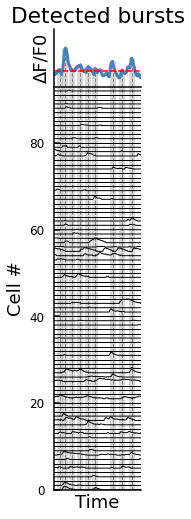

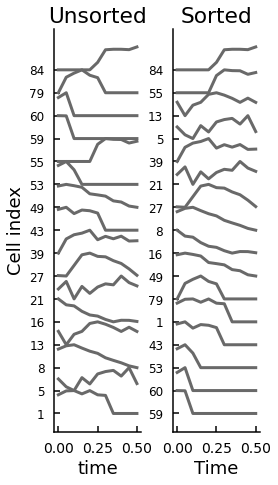

In [8]:
# show an example of sequence detection

winlen=np.shape(STMx2)[1]-1
poprate,id_peaks,bursts,seqs= mot.binned_burst(STMx2,winlen,thr_burts,fs,timewins=[])

#xlim=[9330,11500]
xlim=[12430,12550]

speed_trl=[]
fig, fig2, ax, ax0, ax1, ax2 = mot.plot_sequences_new(STMx2,seqs,bursts,id_peaks,thr_burts,fs,speed_trl,np.asarray(poprate),xlim)

#ax0.set_xlim([10, 100])
#ax.set_xlim([10, 100])

ax0.set_xlim([220,400])
ax.set_xlim([220,400])

ax.set_ylim([0, 320])
hide_spines(ax=ax)
hide_spines(ax=ax0)
hide_spines(ax=ax1)
hide_spines(ax=ax2)

# fig.savefig(savefolder+'sample Burst.svg',dpi=300)
# fig2.savefig(savefolder+'sample Burst sorted.svg',dpi=300)

# plt.show()

# plt.xlim([10,111])
# plt.xlim([10,141])

In [9]:
combined_dicts = [data_all_sessions, session_mask ,data]
with open(savefolder+fol+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer','wb') as f:
    pickle.dump(combined_dicts, f)       


## Generate masks for differenct behaviral epochs

In [10]:
all_data={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
'Spike_times_cells':[],'t':[],'extract':[],'seqs':[]}


conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number


cond_info={}
phase_idx=[]
sess_idx=[]
cond_idx=[]
burst_idx_cond=[]
burst_idx_phase=[]
burst_idx_sess=[]
i0=0

features=['pop_rate', 'xloc', 'yloc', 'fr', 'seq_mask', 'speed',  'lin_pos','bursts','seqs']
features_t=['t', 'id_peaks']

sess_info={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
'Spike_times_cells':[[] for _ in range(ncells)],'t':[],'extract':[],'seqs':[],'trial_idx_mask':[]}

cell_mask_cond = [[] for _ in range(ncells)]
cell_mask_sess = [[] for _ in range(ncells)]
cell_mask_phase = [[] for _ in range(ncells)]
cell_mask_correct = [[] for _ in range(ncells)]




Masks={'conditions':[],'sessions':[],'phases':[],'bursts_cond':[],'bursts_sess':[],'bursts_phase':[],
'odd_even':[],'odd_even_seqs':[],'cell_cond':  cell_mask_cond,'cell_sess':  cell_mask_sess,'cell_phase': cell_mask_phase,'cell_correct':cell_mask_correct,
'correct_failed':[],'correct_failed_seqs':[],'correct_failed_fr':[],'fr_phase':[],'fr_cond':[],'fr_sess':[],'odd_even_fr':[],
'correct_trial_idx_mask':[0],'failed_trial_idx_mask':[0],'trial_idx_mask':[],'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],
'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_number':[],'Spike_binary_cells':[],'Spike_binary':[]}


binray_spike_all=[]
binray_spike_all_cells=[]
a=[[] for _ in range(ncells)]
for sess_name in data_all_sessions.keys():

    odd_even_mask_sess=[]
    sess_trace=[]


    for condname in conds:
       
        cond_info[condname]={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
        'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
        'Spike_times_cells':[],'t':[],'extract':[],'trial_number':[]}
        if ('correct_trials' not in condname) | ( 'loc'  not in condname):




            
            if len(data_all_sessions[sess_name][condname]['t'])>0:
                t0=data_all_sessions[sess_name][condname]['t'][0]# first time of  each chunk

                cond_info[condname]['id_peaks'].extend(data_all_sessions[sess_name][condname]['id_peaks'])
                cond_info[condname]['pop_rate'].extend(np.asarray(data_all_sessions[sess_name][condname]['pop_rate']))


                for fname in features:
                    sess_info[fname].extend(data_all_sessions[sess_name][condname][fname])# pooled data of all conds of alls sess


                binray_spike_all.extend(data_all_sessions[sess_name][condname]['binary_spike'])

                binray_spike_all_cells.extend(data_all_sessions[sess_name][condname]['binary_spike_cells'])


                if  len(sess_info['extract']) == 0:  # If the list is empty
                    sess_info['extract']= np.array(np.transpose(data_all_sessions[sess_name][condname]['extract']))
                    #print("The list is empty")
                else:
                    sess_info['extract'] = np.hstack((sess_info['extract'], np.array(np.transpose(data_all_sessions[sess_name][condname]['extract']))))


                if 'learning' in sess_name:
                    phi=0
                elif 'learned' in sess_name:
                    phi=1

                for i, subsublist in enumerate(np.transpose(data_all_sessions[sess_name][condname]['binary_spike_cells'])):
                    #sess_info['Spike_times_cells'][i].extend(subsublist-t0+i0)# add spike time of each cell from another session/contition
                    # indicates to what condition and waht session this burst belong

                    Masks['cell_cond'][i].extend(cond_number[condname]*np.ones(np.sum(subsublist==1)))
                    Masks['cell_sess'][i].extend(session_mask[sess_name]*np.ones(np.sum(subsublist==1)))
                    Masks['cell_phase'][i].extend(phi*np.ones(np.sum(subsublist==1)))
                    Masks['cell_correct'][i].extend(np.asarray(data_all_sessions[sess_name][condname]['correct_failed_mask'])[np.asarray(subsublist).astype(bool)].astype(bool))

                i0=i0-data_all_sessions[sess_name][condname]['t'][0]+data_all_sessions[sess_name][condname]['t'][-1]

                Masks['correct_failed'].extend(data_all_sessions[sess_name][condname]['correct_failed_mask'])
                Masks['correct_failed_seqs'].extend(data_all_sessions[sess_name][condname]['correct_failed_bursts_mask'])

                Masks['trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['trial_numbers']))
                Masks['correct_trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['correct_trial_idx_mask'])+Masks['correct_trial_idx_mask'][-1])
                Masks['failed_trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['failed_trial_idx_mask'])+Masks['failed_trial_idx_mask'][-1])
                Masks['correct_failed_fr'].extend(data_all_sessions[sess_name][condname]['correct_failed_fr_mask'])# mask for sequence fr 
                Masks['fr_phase'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                Masks['fr_cond'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                Masks['fr_sess'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                Masks['correct_trial_idx_mask_fr'].extend(data_all_sessions[sess_name][condname]['correct_trial_idx_mask_fr'])
                Masks['correct_trial_idx_mask_burst'].extend(data_all_sessions[sess_name][condname]['correct_trial_idx_mask_burst'])
                Masks['failed_trial_idx_mask_fr'].extend(data_all_sessions[sess_name][condname]['failed_trial_idx_mask_fr'])
                Masks['failed_trial_idx_mask_burst'].extend(data_all_sessions[sess_name][condname]['failed_trial_idx_mask_burst'])
                Masks['phases'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))
                
                # indicates to what condition and waht session this burst belong
                Masks['bursts_cond'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))
                Masks['bursts_sess'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))
                Masks['bursts_phase'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))

                # indicates the data of each session
                Masks['sessions'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))

                # indicates the condtions (sampling/reward ...) 
                Masks['conditions'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))
                Masks['trial_number'].extend(np.asarray(data_all_sessions[sess_name][condname]['trial_numbers']))
sess_info['id_peaks']=np.where(binray_spike_all)[0]
sess_info['trial_idx_mask']=Masks['trial_idx_mask']

sess_info['Spike_times_cells']=[np.where(arr)[0] for arr in np.transpose(binray_spike_all_cells)]# add spike time of each cell from another session/contition

sess_info['Spike_binary_cells']=np.transpose(binray_spike_all_cells)
sess_info['Spike_binary']=binray_spike_all

sess_info['t']=np.arange(len(binray_spike_all_cells))

#sess_info['session_mask']=session_mask# number of each seassion used for masking

In [11]:
Mask_and_sess = [Masks, session_mask]

# with open(savefolder+fol+'Mask_with_correct_cells','wb') as f:
#     pickle.dump(Mask_and_sess, f) 

In [12]:
# ## some visualizations. Can be commented just for visualiztion!
# # example of spike raster detected from the tranisent neural activity of all cells

# plt.imshow(sess_info['Spike_binary_cells'],vmin =0, vmax=.05, aspect='auto', cmap='gray_r',origin='lower',alpha=.9)

# ## visualize the transient rasters with rastermap

# model = Rastermap(n_components=1, n_X=90).fit(sess_info['extract'])# compute raster map based on the data of task x
# # compute correlation between speed and each cells activity

# isort = np.argsort(model.embedding[:,0])


# Sfilt=sess_info['extract'][isort, :]
# Sfilt = stats.zscore(Sfilt, axis=1)
# sorted_seqs=[]
# for seq in seqs:
#     sorted_seqs.append(np.ravel([np.where(isort==x)[0] for x in seq]))# sorting seqs according to rastermap



# plt.figure(figsize=(42,12))
# plt.subplot(211)

# plt.plot(np.asarray(sess_info['pop_rate'])/100,color='r')
# plt.eventplot(sess_info['id_peaks'])
# #plt.plot(sess_info['speed'],alpha=.2)
# plt.title(fol+'  Threshold=' +str(thr_burts),fontsize=34)
# plt.xlim([90010,100000])
# plt.ylim([0,3])

# plt.subplot(212)
# plt.imshow(Sfilt,vmin =0, vmax=3, aspect='auto', cmap='gray_r',origin='lower',alpha=.9)
# plt.xlim([90010,100000])

## Cluster all detected sequences

c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools2.py:529: RuntimeWarning: invalid value encountered in true_divide
  cofseq = (itax @ vec.transpose()) / nvec


cluster [] is removed
Shape of bmat_temp_new: (32, 32)
Excluded clusters: [] Mixed clusters: [ 4.26717642  0.         31.        ]


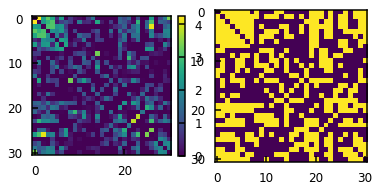

Shape of bmat_temp_new: (31, 31)
Excluded clusters: [] Mixed clusters: [4.26427702 0.         1.        ]


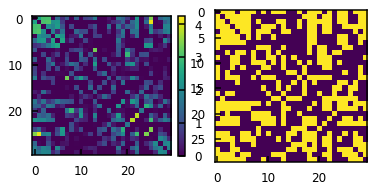

Shape of bmat_temp_new: (30, 30)
Excluded clusters: [] Mixed clusters: [ 4.11425957  1.         25.        ]


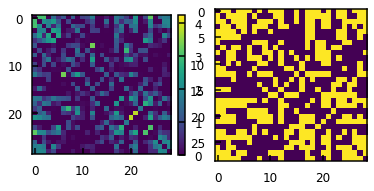

Shape of bmat_temp_new: (29, 29)
Excluded clusters: [] Mixed clusters: [ 3.84587836 20.         21.        ]


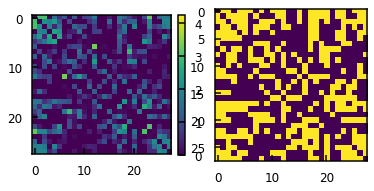

Shape of bmat_temp_new: (28, 28)
Excluded clusters: [] Mixed clusters: [ 3.36033277  6.         12.        ]


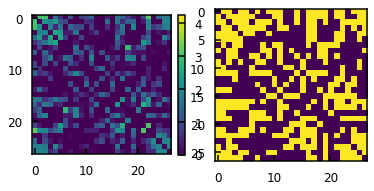

Shape of bmat_temp_new: (27, 27)
Excluded clusters: [] Mixed clusters: [ 3.20476514  0.         22.        ]


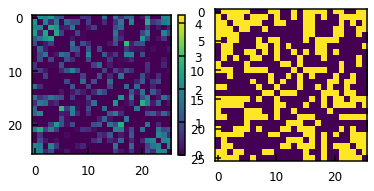

Shape of bmat_temp_new: (26, 26)
Excluded clusters: [] Mixed clusters: [ 2.86135841  5.         17.        ]


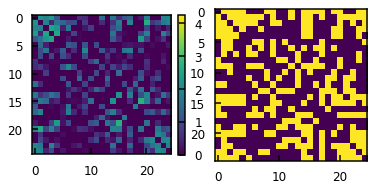

Shape of bmat_temp_new: (25, 25)
Excluded clusters: [] Mixed clusters: [ 2.71449527 15.         19.        ]


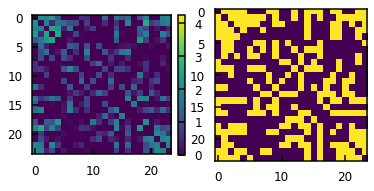

Shape of bmat_temp_new: (24, 24)
Excluded clusters: [] Mixed clusters: [ 2.63840295  1.         19.        ]


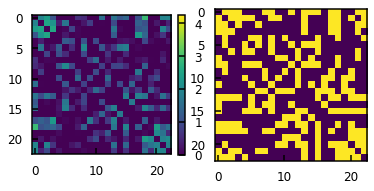

Shape of bmat_temp_new: (23, 23)
Excluded clusters: [] Mixed clusters: [ 2.91138468  0.         18.        ]


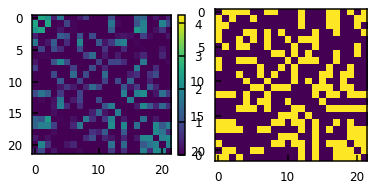

Shape of bmat_temp_new: (22, 22)
Excluded clusters: [] Mixed clusters: [2.55212876 1.         2.        ]


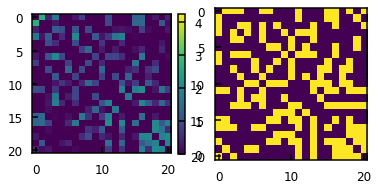

Shape of bmat_temp_new: (21, 21)
Excluded clusters: [] Mixed clusters: [2.71389182 0.         1.        ]


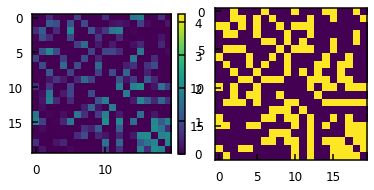

In [13]:
# clustering sequences

seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
bursts=sess_info['bursts']
plot_figure=True

#*************** compute clusters from sequences ***************
repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(seqs,nrm);
ids_clust = mot.cluster(bmat,zmat,clstr_param)
temp_info = mot.templates(bursts,seqs,nrm,ids_clust,min_ratio = min_ratio)
print('cluster', temp_info['exclude'] ,'is removed')
#temp_info_org=np.copy(temp_info['template'])
temp_info_test = copy.deepcopy(temp_info)
temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,seqs,bursts,plot_figure,min_ratio=.1,z_thr=2.5)
#id_peaks=dats['sp_idpeak']
sess_info['ids_clust'] = temp_info_new['ids_clust'][0]
sess_info['template'] = temp_info_new['template']

if len(sess_info['template']) != len(np.unique(sess_info['ids_clust'])):# retrun error if cluster number and template length are not equal
    raise ValueError("Template lenght must be qual to cluter numbers")

sess_inf_plus_mask= {'sess_info': sess_info, 'Masks': Masks}
# with open(savefolder+fol+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
#     pickle.dump(sess_inf_plus_mask, f) 

with open(savefolder+fol+'Sesseion_info'+'test','wb') as f:
    pickle.dump(sess_inf_plus_mask, f) 

In [27]:
see_info_old=np.load(savefolder+fol+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor,allow_pickle=True)

In [19]:
sess_info_new=sess_inf_plus_mask['sess_info']

In [28]:
sess_info_old_=see_info_old['sess_info']

(2000.0, 2100.0)

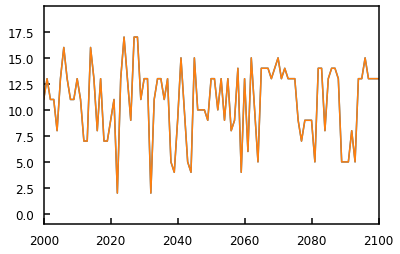

In [34]:
plt.plot(sess_info_new['ids_clust'])
plt.plot(sess_info_old_['ids_clust'])
plt.xlim([2000,2100])

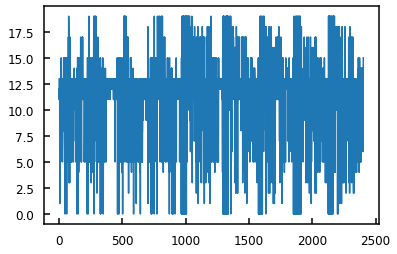

In [14]:
plt.plot(sess_info['ids_clust'] )

In [15]:
## run til here, the folloig cods are not used for the manuscript

In [16]:
stop

NameError: name 'stop' is not defined

# Clustering shuffled sequences

In [ ]:
# shuffled_seqs=[]
# shuffled_bursts=[]
# for iseq, seq in enumerate(seqs):

#     indices = np.arange(len(seq))
#     np.random.shuffle(indices)
#     shuffled_seqs.append(seq[indices])
#     shuffled_bursts.append(replace_rows(bursts[iseq], seq, seq[indices]))

In [ ]:
#poprate,id_peaks,bursts,seqs,spike_times,rasters = mot.binned_burst(dats['sp_data'],winlen,thr_burts,fs,timewins)
# seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
# bursts=sess_info['bursts']

plot_figure=True


# #id_peaks=sess_info['id_peaks']
# #*************** compute clusters from sequences
# repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(shuffled_seqs,nrm);
# ids_clust = mot.cluster(bmat,zmat,clstr_param)
# temp_info = mot.templates(shuffled_bursts,shuffled_seqs,nrm,ids_clust,min_ratio = min_ratio)
# print('cluster', temp_info['exclude'] ,'is removed')
# #temp_info_org=np.copy(temp_info['template'])
# temp_info_test = copy.deepcopy(temp_info)
# temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,shuffled_seqs,shuffled_bursts,plot_figure,min_ratio=.1,z_thr=2.5)
# #id_peaks=dats['sp_idpeak']
# sess_info['ids_clust'] = temp_info_new['ids_clust'][0]
# sess_info['seqs']=shuffled_seqs
# sess_info['bursts']=shuffled_bursts

# sess_inf_plus_mask= {'sess_info': sess_info, 'Masks': Masks}
# with open(savefolder+fol+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
#     pickle.dump(sess_inf_plus_mask, f) 

# Apply the masks and get the part of data you need. 

### Save data of outward runs for Place feild analysis

In [ ]:

# add the mask for speed. speed threshold is set to 5.
smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
Masks['speed']=smooth_speed>speed_thr


# select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
#sessin_numbers=[6]
#sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
#celid=23# number of sample cell to show in the plot

#cond_number=[3] # conditon name (outwards)
#cond_number=[8,9,10,11] # inwards
#cond_number=[0,1] # sampling
#cond_number=[6,7] # reward
for cond_number in ([2,3]):
        
    trial_type=0 # 1 is correct       0 is failed

    if trial_type==1:
        type_name='correct'
    elif trial_type==0:
        type_name='failed'



    phase=None#None#,1 # 0 is learning,    1 is learned,  None is both
    if phase==None:
        phase_name='all'
    elif phase==0:
        phase_name='learning'
    elif phase==1:
        phase_name='learned'
            


    # odd_even=1# even trials
    # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

    # odd_even=0# odd trials
    # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

    odd_even=None# all trials
    run_data_all=mot.apply_masks_test(sess_info,Masks,[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



    reversed_mapping = {v: k for k, v in cond_names.items()}
    print(reversed_mapping.get(cond_number,'Key not found'),len(run_data_all['trace_cells']))
    animal_direction=reversed_mapping.get(cond_number,'Key not found')
    #animal_direction = mot.find_condition(cond_number,cond_names)
    #print(animal_direction)
    run_data_all['template']=sess_info['template']
    with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        pickle.dump(dict(run_data_all), f)   
    #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')


outward_L 87
outward_R 87


c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3449: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]


In [ ]:
## to get the merged data of sampling, outward and reward for burst replay analysis 
cell_types='All'
descriotor='No_chunk_0.5s_transients'
for fol in ['478','481','483','485']:

    #savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
    #savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
    #filename = '48520220215_gcamp6f485_task_learning.mat_all_sessions_all_days_transients'
    #filename = fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_neworder'+burst_len+'_transients_'+celltype
    #fol='481'
    #phase='all'
    filename = fol+'Sesseion_info_All AllNo_chunk_0.5s_transients'

    #filename = '478outward_R_all_correct_all_days_randomized_bursts_200ms_transients_allnew'

    data_all_tasks = np.load(join(savefolder, filename), allow_pickle=True)
    sess_info= data_all_tasks['sess_info']
    #Masks= data_all_tasks['Masks']# this mask does not include mask of correct trials of single cells


    filename_mask = fol+'Mask_with_correct_cells'
    Masks_ = np.load(join(savefolder, filename_mask), allow_pickle=True)# i added the correct masks for single cell data recently
    Masks=Masks_[0]


    #data_info=np.load(savefolder+fol+'data_all_sessions'+cell_types+'_'+ descriotor+'newodrer', allow_pickle=True)
    session_mask=Masks_[1]







 
    # add the mask for speed. speed threshold is set to 5.
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr


    # select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
    sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
    #sessin_numbers=[6]
    #sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
    #celid=23# number of sample cell to show in the plot

    #cond_number=[3] # conditon name (outwards)
    #cond_number=[8,9,10,11] # inwards
    #cond_number=[0,1] # sampling
    #cond_number=[6,7] # reward
    for con_number in ([1,3,5],[0,2,4],[0,2,4,1,3,5]):
            
        trial_type=1 # 1 is correct       0 is failed

        if trial_type==1:
            type_name='correct'
        elif trial_type==0:
            type_name='failed'



        phase=None#None#None#,1 # 0 is learning,    1 is learned,  None is both
        if phase==None:
            phase_name='all'
        elif phase==0:
            phase_name='learning'
        elif phase==1:
            phase_name='learned'
                


        # odd_even=1# even trials
        # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

        # odd_even=0# odd trials
        # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

        odd_even=None# all trials
        run_data_all=mot.apply_masks_test(sess_info,Masks,con_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)



        name_of_conds=' '.join([xn for xn,x in cond_names.items() if x in con_number])

        run_data_all['template']=sess_info['template']
        # with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        #     pickle.dump(dict(run_data_all), f)   
        #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')
        # with open(savefolder+fol+name_of_conds+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder_with_templates','wb') as f:
        #     pickle.dump(dict(run_data_all), f) 

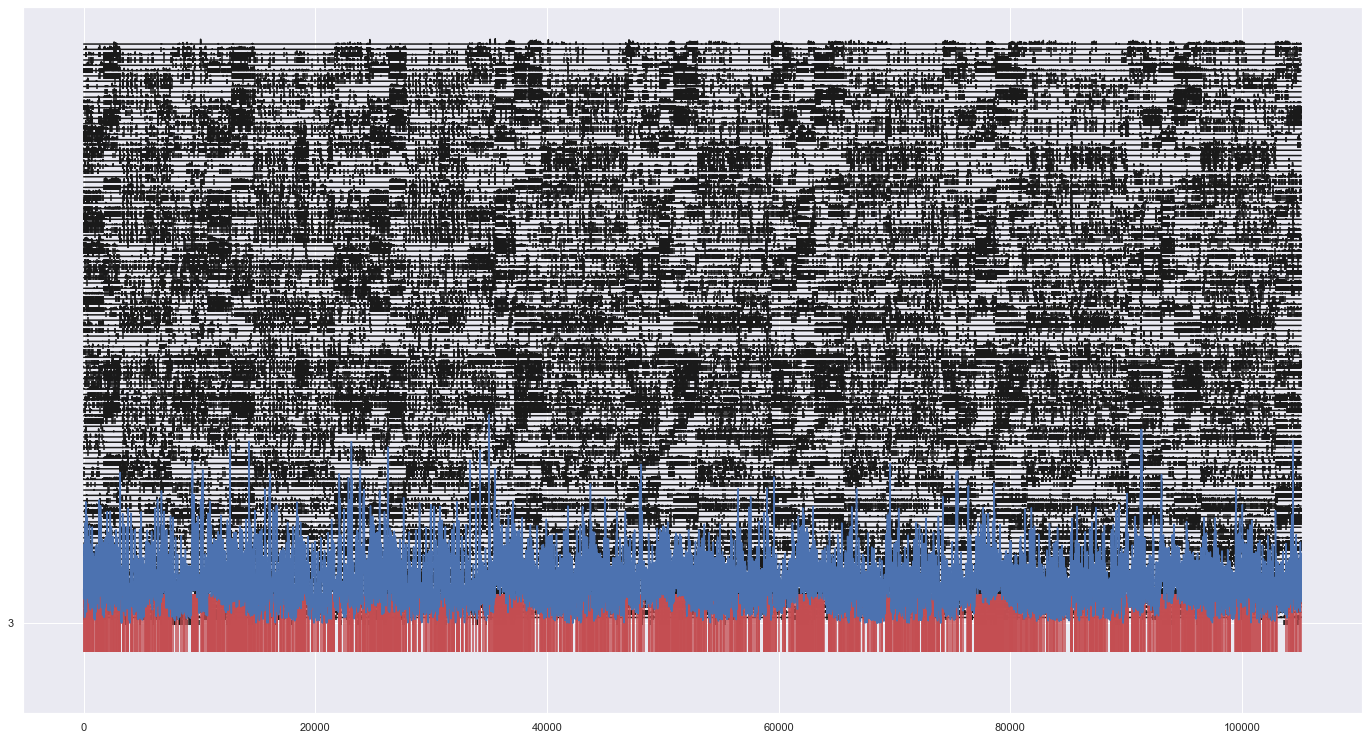

In [ ]:
plt.figure(figsize=(24,13))
for nr in range(len (sess_info['Spike_times_cells'])):
    plt.eventplot(sess_info['Spike_times_cells'][nr],linelengths=1,lineoffsets=nr,color='k')

    plt.plot(nr+1+sess_info['extract'][nr]/np.max(sess_info['extract'][nr]),color='k')

#plt.eventplot(data['spike_idx_cells'][1],linelengths=21,lineoffsets='4',color='k')

plt.eventplot(sess_info['id_peaks'],lineoffsets='3',color='r',linelengths=11)

plt.plot(np.asarray(sess_info['pop_rate'])/10)
#plt.xlim([0,2111])

In [ ]:

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Get the first four colors
first_four_colors = color_cycle[:4]



## Finde the precentage of the place cells in a sequences

## plot the distribution of each cluster

In [ ]:
n_clusters=np.max(sess_info['ids_clust'])+1


In [ ]:
Cluster_cunts_all={}
phase_c_f=1
state_c_f=1
n_clusters=np.max(sess_info['ids_clust'])+1

if phase_c_f==1:
    datamaode='Learned'
elif phase_c_f==0:
    datamaode='Learning'


if state_c_f==1:
    trialsmode='Correct'
elif state_c_f==0:
    trialsmode='Failed'



for icls,cls in enumerate(np.unique(sess_info['ids_clust'])):# itterat on clusters
    Cluster_cunts={}

    mas_clstr=(sess_info['ids_clust']==cls)# mask of one cluster

    learning_or_learned_mask=np.asarray(Masks['bursts_phase'])==phase_c_f
    correct_or_failed_mask= np.asarray(Masks['correct_failed_seqs'])==state_c_f

    dd=np.asarray(Masks['bursts_cond'])[mas_clstr & correct_or_failed_mask  & learning_or_learned_mask]
    
    
    # bursts on one cluster
    for kk in range(len(cond_names)):# itteration on condtions
        sumsclstr=[]
        #for dk in range(len(cond_names)):

        if list(cond_names.items())[kk][1]==kk:
            Cluster_cunts[list(cond_names.items())[kk][0]]=np.sum(dd==kk)

    Cluster_cunts_all[str(icls)]=Cluster_cunts



In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt


# plt.rcParams.update({'font.size': 19})
# plt.rcParams['axes.titlesize'] = 19  # Set the title font size
# plt.rcParams['xtick.labelsize'] = 11  # You can adjust the font size as needed
# plt.rcParams['ytick.labelsize'] = 15  # You can adjust the font size as needed

# j = 4#int(np.ceil(np.sqrt(n_clusters)))
# k = 5#int(np.ceil(n_clusters / j))
# fig, axes = plt.subplots(j, k, figsize=(14, 8), sharex=True, sharey=True)
# axes = axes.flatten()

# for cltr_nbr_data in Cluster_cunts_all.keys():


# # Convert the data to a format suitable for Seaborn


#     merged_data = {'sampling': Cluster_cunts_all[cltr_nbr_data]['sampling_L'] + Cluster_cunts_all[cltr_nbr_data]['sampling_R'],
#                'outward': Cluster_cunts_all[cltr_nbr_data]['outward_L_center'] + Cluster_cunts_all[cltr_nbr_data]['outward_L_side'] + Cluster_cunts_all[cltr_nbr_data]['outward_R_center'] + Cluster_cunts_all[cltr_nbr_data]['outward_R_side'],
#                'reward': Cluster_cunts_all[cltr_nbr_data]['reward_L'] + Cluster_cunts_all[cltr_nbr_data]['reward_R'],
#                'inward': Cluster_cunts_all[cltr_nbr_data]['inward_L_side'] + Cluster_cunts_all[cltr_nbr_data]['inward_L_center'] + Cluster_cunts_all[cltr_nbr_data]['inward_R_side'] + Cluster_cunts_all[cltr_nbr_data]['inward_R_center']}

#     data_list = [{'Category': key, 'Value': value} for key, value in merged_data.items()]

#     # Create a DataFrame from the data
#     import pandas as pd
#     df = pd.DataFrame(data_list)

#     # Set the plot style (optional)

#     # Create a bar plot using Seaborn
#     #plt.figure(figsize=(5, 3))
#     sns.set()
#     #colors = sns.color_palette("default", n_colors=4)
    
#     current_palette = sns.color_palette()
#     sns.set(style="whitegrid")

#     sns.barplot(x='Category', y='Value', data=df, ax=axes[int(cltr_nbr_data)],palette=current_palette)

#     # Rotate x-axis labels for better readability
#     #axes[int(cltr_nbr_data)].set_xticks(rotation=90, ha='right')

#     # # Adding labels and title
#     #axes[int(cltr_nbr_data)].set_xlabel('Consitions')
#     axes[int(cltr_nbr_data)].set_xlabel('',fontsize=15)
#     axes[int(cltr_nbr_data)].set_ylabel('Sequence #' if int(cltr_nbr_data) % k == 0 else '',fontsize=16)
#     axes[int(cltr_nbr_data)].set_title('Cluster '+ cltr_nbr_data,fontsize=20)
#     # #plt.ylim([0,120])
#     # # Display the plot

# for i in range(n_clusters, j * k):
#     fig.delaxes(axes[i])

# plt.suptitle(fol+' '+datamaode+' '+trialsmode,fontsize=22)
# plt.tight_layout()
# plt.show()


In [ ]:
colorlist=["#FFD700",
"#00FFFF",
"#7346d0",
"#72d658",
"#d65171",
"#c09294",
"#6678c6",
"#ae3e83",
"#FFA500",#
"#4a7875",
"#cdd24b",
"#7b332e",
"#c98ccc",
"#d74f34",
"#45314e",
"#cf4dcc",
"#5f893e",
"#cac795",
"#c48840",
"#4f2a7e"]

#colorlist[-1]='#E5E5E5'# make bad cluster gray